# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [209]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns
import os

Будем использовать torchvision для работы с данными.

In [210]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [221]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [219]:
torch.manual_seed(0)
train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:500])
val_dataset = torch.utils.data.Subset(val_dataset, torch.randperm(len(val_dataset))[:100])

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [213]:
def denormalize_image(image):
    return (image + 1) / 2

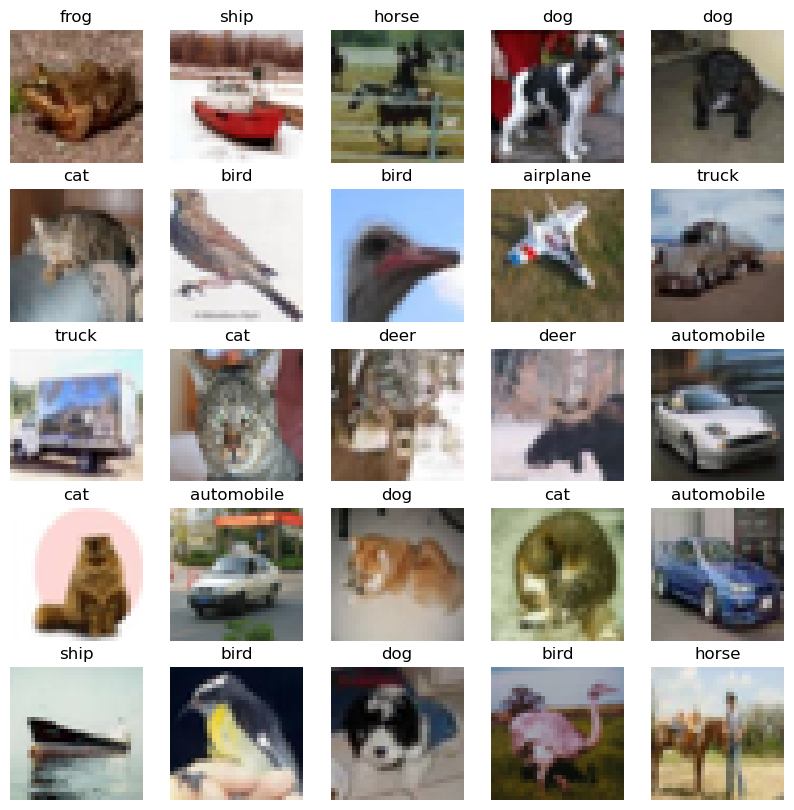

In [218]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [215]:
image.shape

torch.Size([3, 32, 32])

In [222]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [223]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            
            nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            
            nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            
            nn.Conv2d(48, 96, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
        )
        
        self.fc = nn.Linear(384, 256)

        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
         
        return x
        
        ### END SOLUTION

In [224]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).numel() < 1*3*32*32, f'encoder(noise).view(-1).numel() = {encoder(noise).view(-1).numel()}'

In [225]:
class Decoder(nn.Module):
    def __init__(self, output_channels=3, feature_dim=64):
        super().__init__()
        ### BEGIN SOLUTION
        
        super().__init__()
        self.fc = nn.Linear(256, 96*2*2)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),

            nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),

            nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), 
        )
        
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        x = self.fc(x)
        x = x.view(-1, 96, 2, 2)
        x = self.decoder(x)
        return x
        ### END SOLUTION

In [226]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [227]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [228]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1118            3.07m
         2           1.9704            3.00m
         3           1.8596            2.94m
         4           1.7650            2.88m
         5           1.6817            2.82m
         6           1.6069            2.75m
         7           1.5425            2.69m
         8           1.4805            2.63m
         9           1.4255            2.56m
        10           1.3733            2.50m
        20           1.0148            1.88m
        30           0.8118            1.26m
        40           0.6769           37.99s
        50           0.5842            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3758

In [229]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [230]:
encoder.to(device)
decoder.to(device)

Decoder(
  (fc): Linear(in_features=256, out_features=384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

In [231]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [232]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    for images, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        
        # Переносим данные на устройство
        images = images.to(device)

        # Обнуление градиентов
        optim.zero_grad()

        # Прямой проход через encoder и decoder
        encoded = encoder(images)
        decoded = decoder(encoded)

        # Вычисляем MSE ошибку между оригинальными и восстановленными изображениями
        loss = F.mse_loss(decoded, images)

        # Обратное распространение ошибки
        loss.backward()

        # Шаг оптимизации
        optim.step()

        # Сохраняем текущую ошибку
        losses.append(loss.item())
        
        ### END SOLUTION
    return sum(losses) / len(losses)

In [233]:
loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1563 [00:00<?, ?it/s]

0.08023985684089606

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [234]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    for images, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        
        # Переносим данные на устройство
        images = images.to(device)

        # Прямой проход через encoder и decoder
        encoded = encoder(images)
        decoded = decoder(encoded)

        # Вычисляем MSE ошибку
        loss = F.mse_loss(decoded, images)
            
        # Сохраняем текущую ошибку
        losses.append(loss.item())
        
        ### END SOLUTION
    return sum(losses) / len(losses)

In [235]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0.051393671615840866

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [238]:
import os

def full_train(device, train_loader, val_loader):
    weights_path = 'weights.pth'
    
    if os.path.exists(weights_path):
        print("Loading weights.pth")
        
        encoder = Encoder().to(device)
        decoder = Decoder().to(device)
        
        checkpoint = torch.load(weights_path, map_location=device)
        
        encoder.load_state_dict(checkpoint['encoder'])
        decoder.load_state_dict(checkpoint['decoder'])
        return encoder, decoder
    
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')
    
    torch.save({
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict()
    }, weights_path)    
    
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.show()
    return encoder, decoder

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/30
Train MSE loss: 0.0759
Validation MSE loss: 0.0529


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 2/30
Train MSE loss: 0.0496
Validation MSE loss: 0.0441


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 3/30
Train MSE loss: 0.0438
Validation MSE loss: 0.0391


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 4/30
Train MSE loss: 0.0398
Validation MSE loss: 0.0367


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 5/30
Train MSE loss: 0.0369
Validation MSE loss: 0.0336


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 6/30
Train MSE loss: 0.0349
Validation MSE loss: 0.0313


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 7/30
Train MSE loss: 0.0331
Validation MSE loss: 0.0303


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 8/30
Train MSE loss: 0.0318
Validation MSE loss: 0.0295


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9/30
Train MSE loss: 0.0308
Validation MSE loss: 0.0284


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 10/30
Train MSE loss: 0.0295
Validation MSE loss: 0.0271


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 11/30
Train MSE loss: 0.0286
Validation MSE loss: 0.0281


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12/30
Train MSE loss: 0.0278
Validation MSE loss: 0.0263


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 13/30
Train MSE loss: 0.0270
Validation MSE loss: 0.0255


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 14/30
Train MSE loss: 0.0264
Validation MSE loss: 0.0249


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 15/30
Train MSE loss: 0.0259
Validation MSE loss: 0.0247


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 16/30
Train MSE loss: 0.0254
Validation MSE loss: 0.0244


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 17/30
Train MSE loss: 0.0249
Validation MSE loss: 0.0236


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 18/30
Train MSE loss: 0.0244
Validation MSE loss: 0.0226


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 19/30
Train MSE loss: 0.0240
Validation MSE loss: 0.0225


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 20/30
Train MSE loss: 0.0235
Validation MSE loss: 0.0223


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 21/30
Train MSE loss: 0.0232
Validation MSE loss: 0.0232


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 22/30
Train MSE loss: 0.0229
Validation MSE loss: 0.0215


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 23/30
Train MSE loss: 0.0226
Validation MSE loss: 0.0220


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 24/30
Train MSE loss: 0.0224
Validation MSE loss: 0.0209


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 25/30
Train MSE loss: 0.0221
Validation MSE loss: 0.0217


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 26/30
Train MSE loss: 0.0219
Validation MSE loss: 0.0204


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 27/30
Train MSE loss: 0.0217
Validation MSE loss: 0.0213


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 28/30
Train MSE loss: 0.0214
Validation MSE loss: 0.0205


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 29/30
Train MSE loss: 0.0212
Validation MSE loss: 0.0198


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 30/30
Train MSE loss: 0.0210
Validation MSE loss: 0.0201


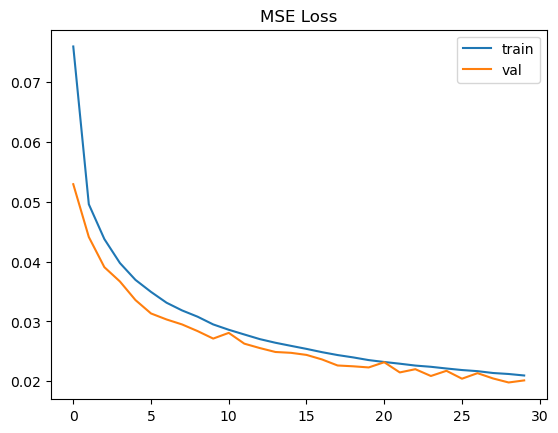

In [239]:
encoder, decoder = full_train(device, train_loader, val_loader)

In [240]:
score = classification_score(encoder, train_dataset, val_dataset, device)
# assert score > 0.39
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.1086            3.06m
         2           1.9743            3.00m
         3           1.8615            2.95m
         4           1.7628            2.88m
         5           1.6784            2.82m
         6           1.6052            2.75m
         7           1.5406            2.69m
         8           1.4803            2.63m
         9           1.4223            2.57m
        10           1.3665            2.50m
        20           0.9836            1.87m
        30           0.7441            1.25m
        40           0.5763           37.47s
        50           0.4548            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3841

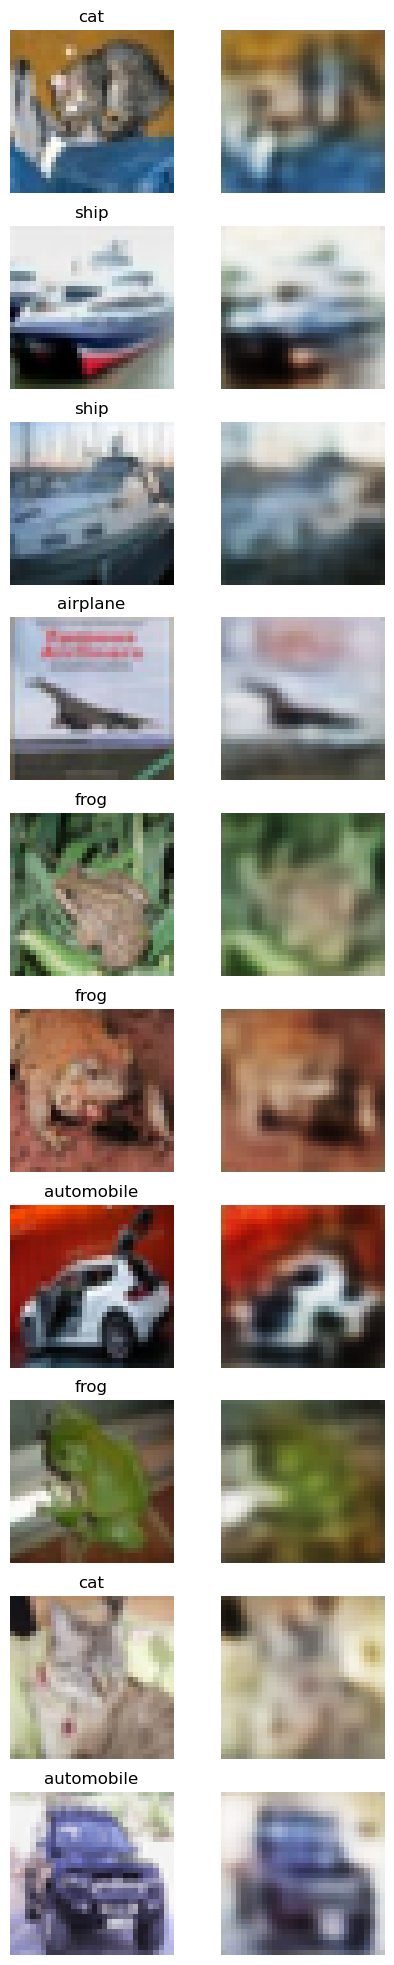

In [241]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [242]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    ### BEGIN SOLUTION
    
    encoder.to(device)
    encoder.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, leave=False):
            images = images.to(device)
            embeddings = encoder(images)
            embeddings = embeddings.cpu()
            labels = labels.cpu()
            for embedding, label in zip(embeddings, labels):
                representations[label.item()].append(embedding)
    return representations
    
    ### END SOLUTION

In [243]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor
assert representations[0][0].shape == (256, )

  0%|          | 0/10000 [00:00<?, ?it/s]

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [244]:
from scipy.linalg import sqrtm

def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    
    mu1 = np.mean(repr1, axis=0)
    mu2 = np.mean(repr2, axis=0)
    
    sigma1 = np.cov(repr1, rowvar=False)
    sigma2 = np.cov(repr2, rowvar=False)
    
    diff = mu1 - mu2
    diff_squared = np.dot(diff, diff)
    
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff_squared + np.trace(sigma1 + sigma2 - 2 * covmean)
    
    return fid
    
    ### END SOLUTION

In [245]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

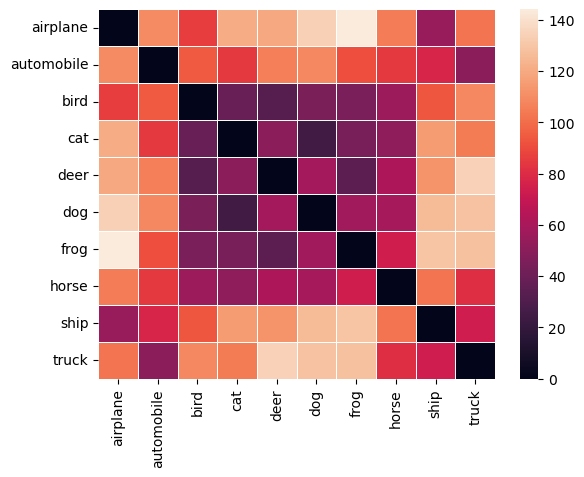

In [246]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

## Задание 3 (3 балла)

Выберите ваш любимый датасет с кошками и собаками и посчитайте FID между двумя классами на новых данных, используя репрезентацию с уже обученного AE

хинт: если любимого датасета с кошками и собаками нет, можно вырезать эти классы из имажнета

хинт: если вам оооочень не нравятся кошки и собаки, то можете выбрать другие два противоположных класса

In [261]:
import zipfile
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

file_path = "data/cats_and_dogs_filtered"

with zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
    
train_dir = os.path.join(file_path, 'train')
val_dir = os.path.join(file_path, 'validation')

In [262]:
val_dataset = ImageFolder(
    root=val_dir, 
    transform=transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
class_names = val_dataset.classes
class_names

['cats', 'dogs']

In [263]:
batch_size = 64
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [265]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder().to(device)
weights_path = 'weights.pth'
checkpoint = torch.load(weights_path, map_location=device)
encoder.load_state_dict(checkpoint['encoder'])
encoder.eval()

Encoder(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (fc): Linear(in_features=384, out_features=256, bias=True)
)

In [266]:
from collections import defaultdict

def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    with torch.no_grad():
        for images, labels in tqdm(dataloader, leave=False):
            images = images.to(device)
            embeddings = encoder(images)
            embeddings = embeddings.cpu()
            labels = labels.cpu()
            for embedding, label in zip(embeddings, labels):
                representations[label.item()].append(embedding)
    return representations

representations = get_representations(val_dataloader, encoder, device)

  0%|          | 0/16 [00:00<?, ?it/s]

In [267]:
fid = calculate_fid(
    repr1=torch.stack(representations[0], dim=0).numpy(),
    repr2=torch.stack(representations[1], dim=0).numpy()
)
fid

36.38484717732465

## Задание 4 (1 балл)

Вы отлично поработали и, скорее всего, в процессе выполнения этих задач у вас появились идеи о том, как еще можно решать подобные проблемы. 

Здесь вы можете описать способы которые вам хотелось бы попробовать если бы у вас было больше времени, или показать статьи которые вы читали, которые решают такие задачи.

Дополнительно, необходимо приложить сюда какой-нибудь смешной мем про генеративные модели за последние два года. Если мем будет не смешным, то баллы придется снять.

In [ ]:
# YOUR CODE HERE